# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></div><div class="lev2 toc-item"><a href="#Parse-input" data-toc-modified-id="Parse-input-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parse input</a></div><div class="lev1 toc-item"><a href="#Overview-visualization" data-toc-modified-id="Overview-visualization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Overview visualization</a></div><div class="lev1 toc-item"><a href="#Differential-expression" data-toc-modified-id="Differential-expression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Differential expression</a></div><div class="lev1 toc-item"><a href="#Summarize-results" data-toc-modified-id="Summarize-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Summarize results</a></div>

# Setup

In [50]:
run <- "batch12_4fold"
expression_fp <- paste0(run, "/full_quant.tsv")
design_fp <- paste0(run, "/design.tsv")

In [51]:
library(ggplot2)
library(ggfortify)
library(ggdendro)
library(limma)
library(gridExtra)

source("~/src/JupyterRReuse/proteomics_multivariate_vis.R")
source("~/src/JupyterRReuse/visualization_utils.R")
source("~/src/JupyterRReuse/proteomics_stats.R")

In [52]:
plot_pca <- function(data_m, design_m, pc1, pc2, color_factor, colors, custom_names, legend=T, title_app="", cont_scale=F) {
    
    if (!cont_scale) {
        getPalette <- colorRampPalette(RColorBrewer::brewer.pal(9, "Set1"))        
    }
    title <- paste0("PCA, PC", pc1, " vs PC", pc2, " ", title_app)
    plt <- make_expression_pca(data_m, design_m, color_factor=color_factor, title=title, 
                               pca_axis1=pc1, pca_axis2=pc2, show_labels=T,
                               only_text=T, color_text=T, custom_names=custom_names)
    if (!cont_scale) {
        plt <- plt + scale_color_manual(values=getPalette(colors))        
    }
    
    if (!legend) {
        plt <- plt + theme(legend.position="none")
    }
    
    plt
}

## Parse input

In [53]:
design_df <- read.csv(design_fp, sep="\t")
design_df$sample <- design_df$name
head(design_df)

name,biorepgroup,techrepgroup,condition,sample
a1,1,1,a,a1
a2,2,1,a,a2
a3,3,1,a,a3
b1,1,1,b,b1
b2,2,1,b,b2
b3,3,1,b,b3


In [57]:
raw_data_df <- read.csv(expression_fp, sep="\t")
head(raw_data_df)
raw_data_df$peptide <- as.character(raw_data_df$peptide)
raw_data_df$protein <- as.character(raw_data_df$protein)
data_df <- log2(raw_data_df[, as.character(design_df$name)])
head(data_df)

peptide,protein,a1,a2,a3,b1,b2,b3,c1,c2,c3,d1,d2,d3,h1,h2,h3,l1,l2,l3
FCR,sp|P0A7T7|RS18_ECOLI,216508408,105302604,188390000,124128396,61146200,26236550,62920800,152758200,37377100,102853200,209932992,132222500,136022196,133833704,133498496,136167600,131757400,138470296
FCQR,sp|P39357|YJHF_ECOLI,197866800,206806500,91024800,188364200,169931000,11359220,100704500,16145970,170408292,171960200,272123292,207982900,130084900,140282600,137579700,137107700,134154800,132605700
KFCR,sp|P0A7T7|RS18_ECOLI,80551000,38286910,69663070,44561130,24265950,9986070,35448080,74736150,18970640,50874540,65054100,40677270,63451290,64289240,62992030,65077360,61875430,66261870
AFVLR,sp|P0ADY1|PPID_ECOLI,19200980,90075804,165011000,173858500,134742100,115509804,93534300,207598108,164900600,115195596,90998196,39363300,111659996,111465996,127039400,115362896,122287700,118226900
GFVLR,sp|P33650|FEOB_ECOLI,86550000,87135504,3652417,51528280,69315800,109990504,72856700,162942500,141686100,142472300,39790400,134808500,116190996,110151000,107943396,113444096,113565300,112812804
MTLFR,sp|P77607|YAGL_ECOLI,181043508,93751004,103779200,32108970,163547800,31742710,193353992,118258500,155655800,178704400,83082600,155814600,153181300,156903300,152223900,144061200,156481200,140866300


a1,a2,a3,b1,b2,b3,c1,c2,c3,d1,d2,d3
27.68985,26.64997,27.48915,26.88726,25.86576,24.64507,25.90703,27.18667,25.15565,26.61601,27.64535,26.97839
27.55995,27.62371,26.43976,27.48895,27.34037,23.43736,26.58555,23.94467,27.34442,27.35750,28.01969,27.63189
26.26340,25.19035,26.05389,25.40928,24.53243,23.25149,25.07920,26.15530,24.17727,25.60044,25.95514,25.27772
24.19468,26.42464,27.29799,27.37334,27.00563,26.78344,26.47899,27.62922,27.29702,26.77951,26.43933,25.23035
26.36703,26.37676,21.80042,25.61886,26.04668,26.71280,26.11856,27.27979,27.07812,27.08611,25.24592,27.00634
27.43176,26.48233,26.62894,24.93647,27.28514,24.91992,27.52667,26.81737,27.21378,27.41300,26.30804,27.21526


In [58]:
head(raw_data_df)

peptide,protein,a1,a2,a3,b1,b2,b3,c1,c2,c3,d1,d2,d3,h1,h2,h3,l1,l2,l3
FCR,sp|P0A7T7|RS18_ECOLI,216508408,105302604,188390000,124128396,61146200,26236550,62920800,152758200,37377100,102853200,209932992,132222500,136022196,133833704,133498496,136167600,131757400,138470296
FCQR,sp|P39357|YJHF_ECOLI,197866800,206806500,91024800,188364200,169931000,11359220,100704500,16145970,170408292,171960200,272123292,207982900,130084900,140282600,137579700,137107700,134154800,132605700
KFCR,sp|P0A7T7|RS18_ECOLI,80551000,38286910,69663070,44561130,24265950,9986070,35448080,74736150,18970640,50874540,65054100,40677270,63451290,64289240,62992030,65077360,61875430,66261870
AFVLR,sp|P0ADY1|PPID_ECOLI,19200980,90075804,165011000,173858500,134742100,115509804,93534300,207598108,164900600,115195596,90998196,39363300,111659996,111465996,127039400,115362896,122287700,118226900
GFVLR,sp|P33650|FEOB_ECOLI,86550000,87135504,3652417,51528280,69315800,109990504,72856700,162942500,141686100,142472300,39790400,134808500,116190996,110151000,107943396,113444096,113565300,112812804
MTLFR,sp|P77607|YAGL_ECOLI,181043508,93751004,103779200,32108970,163547800,31742710,193353992,118258500,155655800,178704400,83082600,155814600,153181300,156903300,152223900,144061200,156481200,140866300


In [59]:
parse_annot <- function(annot_string) {
    
    fields <- unlist(strsplit(as.character(annot_string), "/"))
    annot <- sapply(fields, function(field) { unlist(strsplit(field, "_"))[[2]] })
    
    if (annot == "SOLTU") {
        TRUE
    }
    else if (annot == "ECOLI") {
        FALSE
    }
    else {
        stop(paste0("Unknown annotation: ", annot))
    }
}

In [61]:
spike_col <- sapply(as.character(raw_data_df[, "protein"]), parse_annot)
head(spike_col)


sp|P0A7T7|RS18_ECOLI sp|P39357|YJHF_ECOLI sp|P0A7T7|RS18_ECOLI 
               FALSE                FALSE                FALSE 
sp|P0ADY1|PPID_ECOLI sp|P33650|FEOB_ECOLI sp|P77607|YAGL_ECOLI 
               FALSE                FALSE                FALSE

# Overview visualization

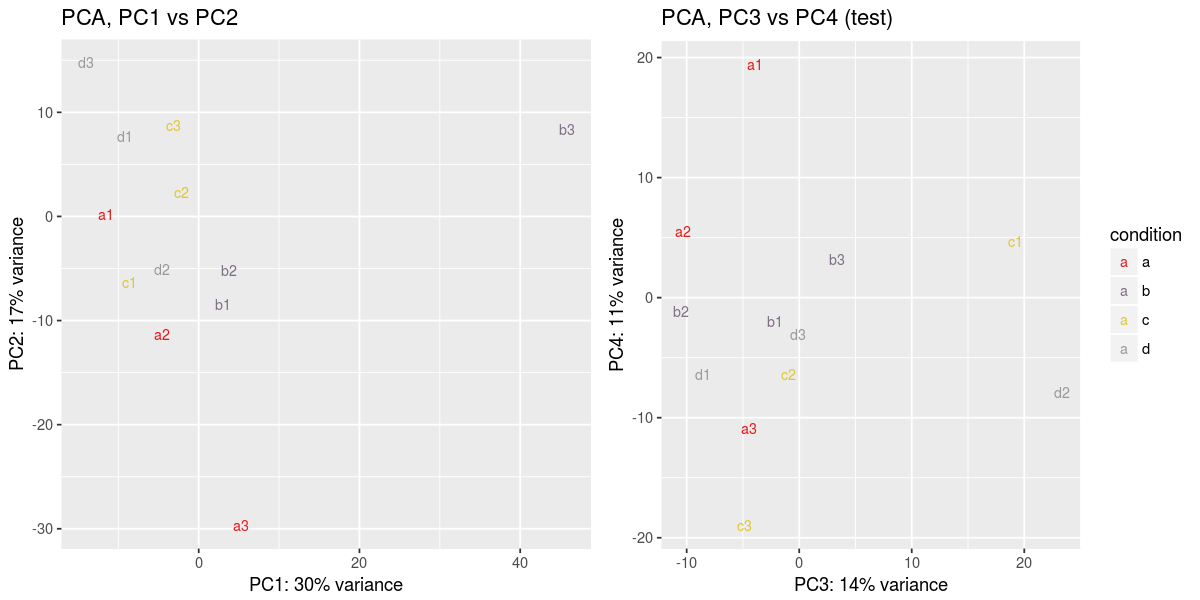

In [63]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "condition", colors=4, custom_names=design_df$name, legend=F)
p1_2 <- plot_pca(data_df, design_df, 3, 4, "condition", colors=4, custom_names=design_df$name, legend=T, title_app="(test)")
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


# Differential expression

In [64]:
calculate_anova <- function(row, cond) {
    
    anova_df <- data.frame(cbind(Intensity=unlist(row), Cond=cond))
    
    av <- aov(Intensity~Cond, anova_df)
    av_summary <- summary(av)
    p_val <- av_summary[[1]]["Cond", "Pr(>F)"]
    p_val
}

In [65]:
p_vals <- apply(data_df, 1, calculate_anova, cond=design_df$condition)
p_vals <- unlist(p_vals)
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))

In [66]:
length(p_vals)

[1] 824

In [31]:
length(p_vals[which(p_vals < 0.1)])
sig_indices <- which(q_vals < 0.1)

[1] 149

In [32]:
length(q_vals[which(q_vals < 0.1)])

[1] 138

In [37]:
length(spike_col[spike_col])

[1] 138

# Summarize results

In [33]:
final_df <- data.frame(peptide=raw_data_df[,"peptide"], 
                  protein=raw_data_df[,"protein"], 
                  spike_col=spike_col, 
                  p_val=p_vals, 
                  q_val=q_vals)


In [34]:
head(final_df)

peptide,protein,spike_col,p_val,q_val
FCR,sp|P0A7T7|RS18_ECOLI,FALSE,0.4862394,0.9985841
LCR,sp|Q9JMR4|YUBK_ECOLI,FALSE,0.1613207,0.8163807
FCQR,sp|P39357|YJHF_ECOLI,FALSE,0.7209347,0.9985841
KFCR,sp|P0A7T7|RS18_ECOLI,FALSE,0.4110247,0.9985841
AFVLR,sp|P0ADY1|PPID_ECOLI,FALSE,0.7015520,0.9985841
GFVLR,sp|P33650|FEOB_ECOLI,FALSE,0.6956976,0.9985841


In [35]:
tail(final_df)

,peptide,protein,spike_col,p_val,q_val
830,IPNLLVNGSSGIAVGMATNIPPHNLTEVINGCLAYIDDEDISIEGLMEHIPGPDFPTAAIINGRR,sp|P0AES4|GYRA_ECOLI,FALSE,0.3847508,0.9985841
831,GYVANSVWTVTAVSGDSVTLSDGQQTREIRPGQEQAEQHIDLAYAITAHGAQGASETFAIALEGTEGNR,sp|P14565|TRAI1_ECOLI,FALSE,0.8037824,0.9985841
832,IPDVMPTKIPNLLVNGSSGIAVGMATNIPPHNLTEVINGCLAYIDDEDISIEGLMEHIPGPDFPTAAIINGR,sp|P0AES4|GYRA_ECOLI,FALSE,0.4187220,0.9985841
833,VITPVFKPIGVHEDNWQATVGLFTGAMAKEVVVGTLNTLYTAENIQDEEFNPAEFNLGEELFSAIDETWQSLK,sp|P33650|FEOB_ECOLI,FALSE,0.5326066,0.9985841
834,YPVTLTPAPEGGYMVSFVDIPEALTQGETVAEAMEAAKDALLTAFDFYFEDNELIPLPSPLNSHDHFIEVPLSVASK,sp|P67697|HICB_ECOLI,FALSE,0.1488137,0.7766214
835,QVLIDSGVGQYISTLVSGMDINPILMAWGVAAFLRICLGSATVAAISTAGLVIPLLAVHPNTNLALITLATGAGSCICSHVNDASFWMIK,sp|P39357|YJHF_ECOLI,FALSE,0.5500526,0.9985841


In [36]:
head(final_df[final_df[, "q_val"] < 0.1, ])

,peptide,protein,spike_col,p_val,q_val
7,GWPYA,sp|P58516|SPI3_SOLTU,TRUE,8.880790e-07,2.660147e-05
9,EFMFYR,sp|P37829|SCRK_SOLTU,TRUE,1.676343e-05,1.052441e-04
17,AFDLMLK,sp|P14674|ADH2_SOLTU,TRUE,9.390030e-06,6.454102e-05
19,CIITMED,sp|P14674|ADH2_SOLTU,TRUE,8.281458e-06,5.971726e-05
33,FAKLLSDR,sp|Q2MY48|PAT03_SOLTU,TRUE,1.370736e-07,2.007176e-05
48,DLDRGWPYA,sp|P58516|SPI3_SOLTU,TRUE,4.163622e-07,2.213554e-05
